<h1> 5. Interactive Data Analysis </h1>

This notebook introduces carrying out interactive data analysis of data in BigQuery using Cloud Datalab.

This cell, for example, is a mark-down cell.  Which is why you are seeing text. The cell that follows is a Python code cell. The output of that cell is whatever is printed out from it.

In [1]:
a = 3
b = a + 5
print("a={} b={}".format(a,b))

a=3 b=8


Because the markdown comments are HTML, it can even include Javascript, for example to create a table of contents, as shown below:

<div id="toc"></div>

In [1]:
!pwd

/Users/alston/Desktop/pycharm_project/alston_course_v1/notebooks/lecture_5/BigQuery


<h2> What's installed? </h2>

In [ ]:
%pip freeze

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

<h2> Installing dependencies </h2>

Regular Python dependencies can be installed using pip

In [6]:
%pip install google-cloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --user --upgrade google-cloud-bigquery

In [ ]:
!pip install --user --upgrade google-cloud-monitoring

In [ ]:
%%bash
sudo apt-get update
sudo apt-get -y install python-mpltoolkits.basemap

<h2> Juypter magic </h2>

In [4]:
%%html
This cell will print out a <b> HTML </b> string.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
client = bigquery.Client()

In [ ]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = client.query(sql).to_dataframe()
df.describe()

In [5]:
%%bigquery
SELECT 
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM flights.tzcorr

frac_delayed
0      0.184268

<h2> Calls to BigQuery </h2>

Let's draw a PDF of different arrival delays

Now, you'll use a random value in a BigQuery query to select about 1% of the dataset. You don't need to look at the whole dataset of 6 million records; a 1% sample is statistically significant enough for this analysis.

In [ ]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = client.query(sql).to_dataframe()
df.describe()

In [6]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM flights.tzcorr
WHERE DEP_DELAY >= 10 AND RAND() < 0.01

In [7]:
df.describe()

ARR_DELAY     DEP_DELAY
count  13426.000000  13509.000000
mean      45.492552     50.594493
std       64.572660     62.424103
min      -52.000000     10.000000
25%       10.000000     17.000000
50%       26.000000     30.000000
75%       58.000000     59.000000
max     1222.000000   1226.000000

You will see results similar to the following. The summary will be slightly different because the RAND() component of the WHERE clause will return a different 1% selection of the data each time the query is executed.  
The DataFrame.describe() function reports the core statistics for the DataFrame returned by the query.


Enter the following Python code in the new cell to display a Seaborn violin chart that shows the distribution dataframe that contains the 1% sample of delay times for flights that departed 10 or more minutes late:

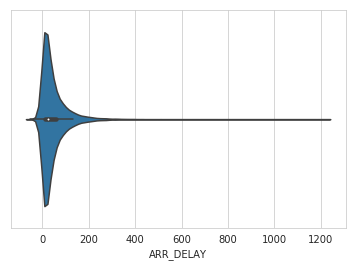

In [8]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
#ax.axes.set_xlim(0, 30)

This chart graphs the distribution of arrival delay values. You can see that the peak in the number of flights that arrive late happens around the 10 minute mark. You can also see that deviations from this peak delay time tend to be more common for delays longer than the peak rather than shorter delays and as you would expect negative delays, i.e. flights arriving ahead of time are relatively rare. One significant feature that has relevance to the overall purpose of these labs in discovering a mechanism to predict arrival delays in real-time is that there is only one peak. This means that the distribution is not bimodal or some other more complex structure.

So now look at the difference between flights that depart more than 10 minutes late and those that depart less than 10 minutes late. You will add a calculated boolean variable called ‘ontime' that allows you to compare this distribution of the arrival time of flights that departed 10 or more minutes late with the distribution for flights that departed less than 10 minutes late.

Enter the following Python code in the empty new cell to create a new dataframe that will then be used to create a Seaborn plot with two violin charts. Since you are going to do the delay threshold calculation here in Pandas, you need to be aware that AI Platform will be working on this dataframe entirely in-memory.

In order to reduce the memory footprint you will now set the WHERE clause in the BigQuery query to return just 0.1% of the data for analysis:

In [9]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM flights.tzcorr
WHERE RAND() < 0.001

In [10]:
df.describe()

ARR_DELAY    DEP_DELAY
count  6127.000000  6150.000000
mean      3.567325     8.412033
std      36.472406    34.001889
min     -51.000000   -26.000000
25%     -13.000000    -5.000000
50%      -5.000000    -2.000000
75%       7.000000     6.000000
max     453.000000   466.000000

In [11]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

ARR_DELAY  DEP_DELAY  ontime
1       14.0       17.0   False
2        2.0       -9.0    True
5       52.0       59.0   False
6       65.0       36.0   False
8      255.0      265.0   False

(-50, 200)

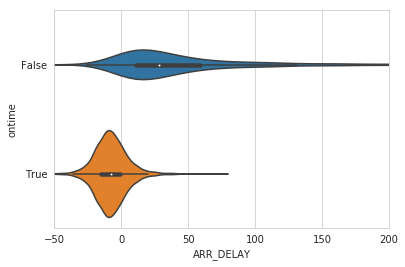

In [12]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200)

The top plot is clipped because Seaborn's default smoothing parameter is too coarse. In order to fix this you need to pass in a more appropriate gridsize parameter. Since you're interested in the data on the left side of this plot, you can narrow down the x axis limits.

(-50, 50)

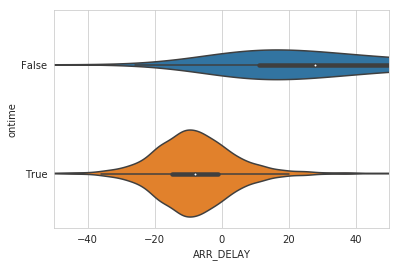

In [13]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 50)

This clearly shows that the 10 minute departure delay threshold definitely divides the dataset into two very different datasets, which is clearly shown by the box plots in the center of these two distributions. Flights that depart 10 or more minutes late are clearly asymmetrically distributed towards longer delay times. Flights that depart less than 10 minutes late are centered around the peak arrival time.

This long tail is a potentially a red flag. You need to analyze the data in more detail to get a better understanding of what is really happening here. Next you'll take a closer look at the range of delay times using BigQuery to see what that can tell you.

In [14]:
%%bigquery depdelay
SELECT
  *
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

In [15]:
depdelay[:5]

DEP_DELAY  arrival_delay  stddev_arrival_delay  numflights
0      -23.0     -23.978389             11.173010         509
1      -22.0     -23.323446             12.355125         708
2      -21.0     -22.549515             12.159491        1030
3      -20.0     -21.536148             12.062171        1563
4      -19.0     -20.628375             12.148920        2185

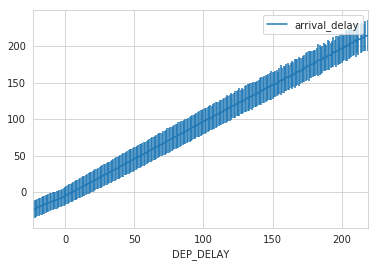

In [16]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', 
              y='arrival_delay', yerr='stddev_arrival_delay')

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


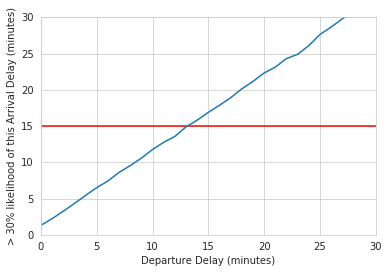

In [17]:
import matplotlib.pyplot as plt
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

In [18]:
%%bigquery depdelay
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

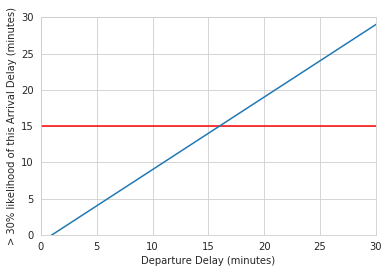

In [19]:
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

In [20]:
%%bigquery depdelay
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

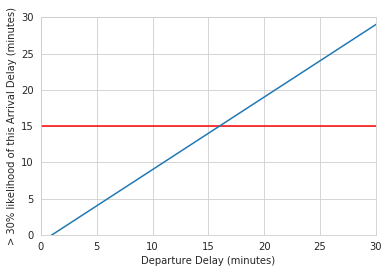

In [21]:
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

In [22]:
%%bigquery eval
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )

In [23]:
print(eval['correct_nocancel'] /
      (eval['correct_nocancel'] + eval['wrong_nocancel']))
print(eval['correct_cancel'] / 
      (eval['correct_cancel'] + eval['wrong_cancel']))

0    0.950439
dtype: float64
0    0.802476
dtype: float64


In [24]:
eval.head()

correct_nocancel  wrong_nocancel  wrong_cancel  correct_cancel
0           1376187           71762         57699          234412

In [25]:
%%bigquery eval
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )

In [26]:
eval.head()

correct_nocancel  wrong_nocancel  wrong_cancel  correct_cancel
0              8368            3146          7370            3157

In [27]:
print(eval['correct_nocancel'] / (eval['correct_nocancel'] + eval['wrong_nocancel']))
print(eval['correct_cancel'] / (eval['correct_cancel'] + eval['wrong_cancel']))

0    0.726767
dtype: float64
0    0.299896
dtype: float64


## Sending to a temporary table

In [28]:
!bq mk temp_dataset

Dataset 'cloud-training-demos:temp_dataset' successfully created.


In [29]:
%%bigquery
CREATE OR REPLACE TABLE temp_dataset.delays
AS

SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

Empty DataFrame
Columns: []
Index: []

In [30]:
!bq rm -f temp_dataset.delays
!bq rm -f temp_dataset